<a href="https://colab.research.google.com/github/baldan555/capstone/blob/main/TireBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
#Importing library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL.Image as image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
#connnect to the drive for the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
#the dataset has been manually divided into 80:20 for train and test in google drive
train_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH//256/train")
validation_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test")

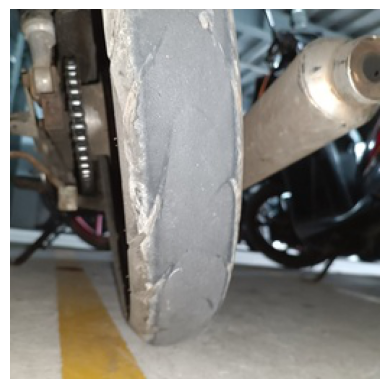

no image


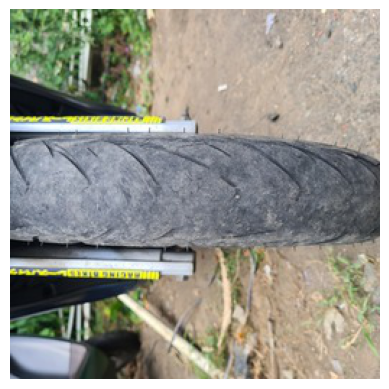

no image


In [178]:
#load the image for showing the example

import os
from PIL import Image
import random
import glob


def read_random_image(folder_path):
    # taking the path of image file
    image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.jpeg"))

    if len(image_files) == 0:
        print("no image")
        return None

    # choosing the file by randomize
    random_image_path = random.choice(image_files)
    image = Image.open(random_image_path)

    # showing the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image

# defining the path
bad_tires_in_training = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/train/kualitas buruk"
good_tires_in_training = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/train/kualitas baik"
bad_tires_in_validation = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test/kualitas buruk"
good_tires_in_validation = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test/kualitas baik"

# read by randomize the file from path
random_image = read_random_image(bad_tires_in_training)
random_image = read_random_image(good_tires_in_training)
random_image = read_random_image(bad_tires_in_validation)
random_image = read_random_image(good_tires_in_validation)

In [179]:
# Define image dimensions and batch size
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16

In [180]:
#defining the data generators for training set
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range = 40,
                                  zoom_range=0.28,
                                  shear_range=0.3,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size= (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   color_mode ='rgb',
                                                   class_mode='binary',
                                                   shuffle=True)

Found 157 images belonging to 2 classes.


In [181]:
#defining the data generators for validatioin set
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        )
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             color_mode ='rgb',
                                                             class_mode='binary',
                                                             shuffle=True)

Found 34 images belonging to 2 classes.


In [182]:
#show the label

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label class from data train and test as well\n")
for key, value in labels.items():
    print(f"{key} : {value}")

#the train datasaet label as well as the dataset label

Label class from data train and test as well

0 : kualitas bagus
1 : kualitas buruk


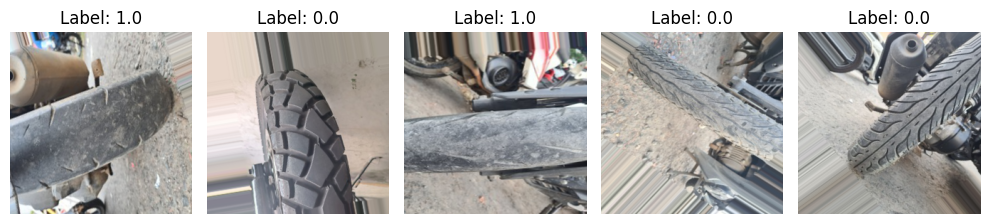

In [183]:
#showing the sample of image from ImageGenerator

import random

num_images = 5
total_batches = len(train_generator)

if num_images > total_batches:
    num_images = total_batches

# get the images randomly
random_indices = random.sample(range(total_batches), num_images)

# plot the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        index = random_indices[i]
        batch_images, batch_labels = train_generator[index]
        ax.imshow(batch_images[0])
        ax.set_title(f"Label: {batch_labels[0]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()



In [184]:
sample_train_images, _ = next(train_generator)
print(sample_train_images.shape)

(16, 256, 256, 3)


In [185]:
sample_valid_images, _ = next(validation_generator)
print(sample_valid_images.shape)

(16, 256, 256, 3)


In [186]:
#defining the model architecture
from tensorflow.keras import regularizers

model = Sequential([

tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


""" model = Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3),
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])"""


" model = Sequential([\n    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3),\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(1024, activation='relu',\n                          kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])"

In [201]:
#using adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay = 1e-4,
                 beta_1=0.8,
                 beta_2=0.999,
                 amsgrad=True)

In [ ]:
#defining the callback ()

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

"""class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        train_accuracy = logs.get("accuracy")
        if val_accuracy > self.threshold and train_accuracy > self.threshold:
            self.model.stop_training = True

callbacks = MyThresholdCallback(threshold=0.92)"""


In [202]:
#compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 30, 30, 64)      

In [203]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator,
                       verbose=2,
                       
                       )

Epoch 1/20
10/10 - 4s - loss: 0.2224 - accuracy: 0.9172 - val_loss: 0.1294 - val_accuracy: 0.9706 - 4s/epoch - 447ms/step
Epoch 2/20
10/10 - 3s - loss: 0.1989 - accuracy: 0.9363 - val_loss: 0.1029 - val_accuracy: 0.9706 - 3s/epoch - 290ms/step
Epoch 3/20
10/10 - 3s - loss: 0.2806 - accuracy: 0.8981 - val_loss: 0.1586 - val_accuracy: 0.9118 - 3s/epoch - 277ms/step
Epoch 4/20
10/10 - 3s - loss: 0.2033 - accuracy: 0.9108 - val_loss: 0.2960 - val_accuracy: 0.8824 - 3s/epoch - 319ms/step
Epoch 5/20
10/10 - 4s - loss: 0.2598 - accuracy: 0.8662 - val_loss: 0.1165 - val_accuracy: 0.9412 - 4s/epoch - 399ms/step
Epoch 6/20
10/10 - 3s - loss: 0.1887 - accuracy: 0.9172 - val_loss: 0.0978 - val_accuracy: 0.9706 - 3s/epoch - 277ms/step
Epoch 7/20
10/10 - 3s - loss: 0.2067 - accuracy: 0.9045 - val_loss: 0.0817 - val_accuracy: 0.9706 - 3s/epoch - 272ms/step
Epoch 8/20
10/10 - 3s - loss: 0.1945 - accuracy: 0.9172 - val_loss: 0.1756 - val_accuracy: 0.9412 - 3s/epoch - 272ms/step
Epoch 9/20
10/10 - 4s - 

In [204]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



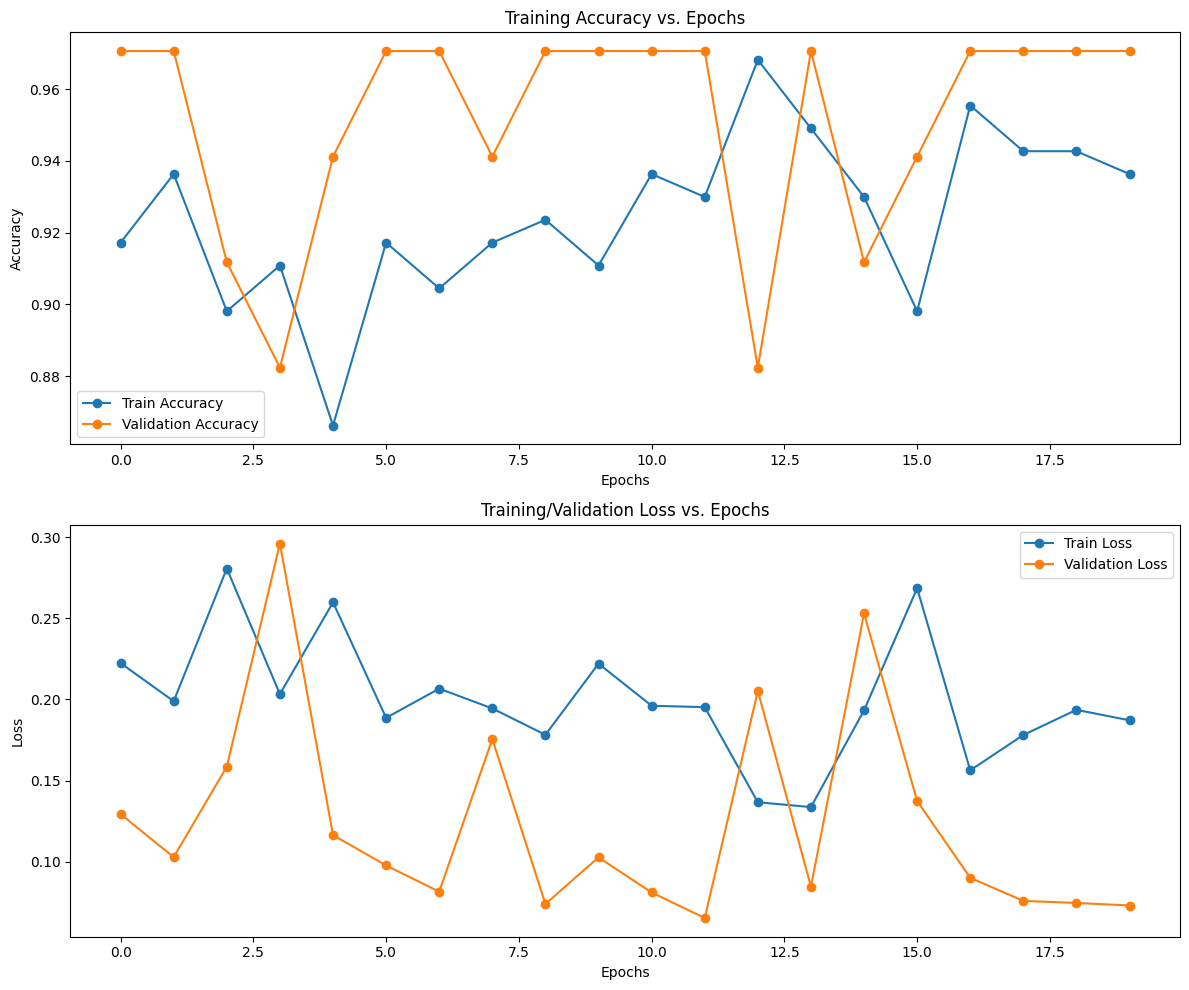

In [205]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')



plt.tight_layout()
plt.show()

In [206]:
test_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/coba")

In [207]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='binary')

Found 76 images belonging to 2 classes.


In [208]:
predictions = model.predict(test_generator)

5/5 [==============================] - 0s 55ms/step


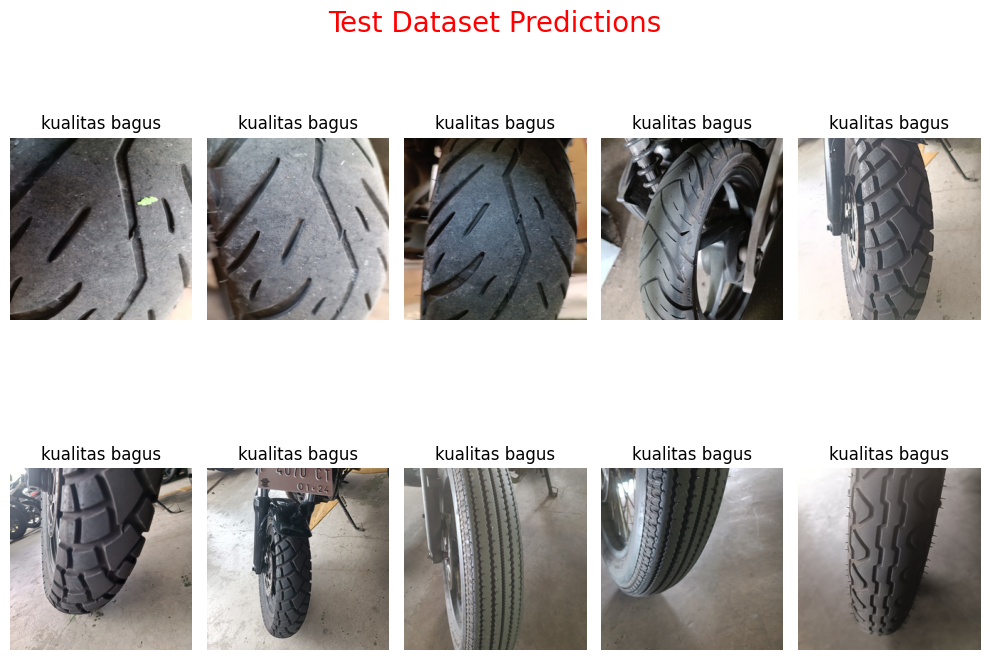

In [105]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20, color = 'red')
plt.show()

In [209]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

5/5 [==============================] - 0s 69ms/step - loss: 0.6715 - accuracy: 0.7368


Saving 20230603_142955.jpg to 20230603_142955 (1).jpg
1/1 [==============================] - 0s 29ms/step
20230603_142955.jpg
Kualitas baik


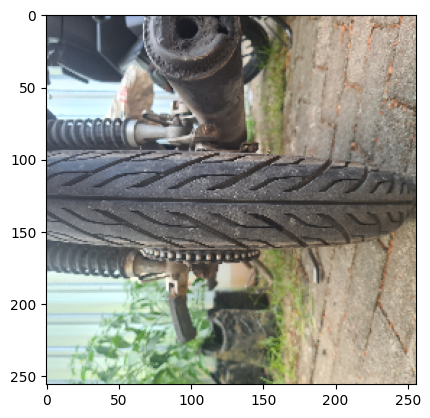

In [212]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(256, 256))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=32)

    print(fn)
    if classes[0, 0] == 1.0:
        print('Kualitas buruk')
    else:
        print('Kualitas baik')


In [ ]:
from tensorflow.keras.models import load_model
import os


In [ ]:
model.save(os.path.join('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model', 'Tirebinary.h5'))

In [ ]:
model = keras.models.load_model('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model_json = model.to_json()

In [ ]:
with open('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
model.save('/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/saved_model')